# Import des outils / jeu de données

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prince
import seaborn as sns
from sklearn.cluster import (
    DBSCAN,
    OPTICS,
    AffinityPropagation,
    AgglomerativeClustering,
    KMeans,
    MeanShift,
)
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler

In [40]:
SEED = 0

In [41]:
np.random.seed(SEED)
sns.set_theme()

In [42]:
df = pd.read_csv(
    "data/data-cleaned-feature-engineering.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

In [43]:
composantes_acp = pd.read_csv("data/composantes_acp.csv", index_col="ID")
composantes_acm = pd.read_csv("data/composantes_acm.csv", index_col="ID")

## Variables globales

In [44]:
var_numeriques = [
    "Year_Birth",
    "Income",
    "Recency",
    "MntWines",
    "MntFruits",
    "MntMeatProducts",
    "MntFishProducts",
    "MntSweetProducts",
    "MntGoldProds",
    "NumDealsPurchases",
    "NumWebPurchases",
    "NumCatalogPurchases",
    "NumStorePurchases",
    "NumWebVisitsMonth",
]

In [45]:
var_categoriques = [
    "Education",
    "Marital_Status",
    "Kidhome",
    "Teenhome",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Response",
]

var_categoriques_extra = ["NbAcceptedCampaigns", "HasAcceptedCampaigns", "NbChildren"]

var_categoriques_fe = var_categoriques + var_categoriques_extra

# Clustering

## Préparation des données

Nous commencer par fusionner les variables quantitatives et les coordonnées des individus dans l'ACM.

In [46]:
X_clust = pd.concat((df[var_numeriques], composantes_acm), axis=1)

In [47]:
X_clust.head()

Year_Birth   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
ID                                                                         
5524        1957  58138.0       58       635         88              546   
2174        1954  46344.0       38        11          1                6   
4141        1965  71613.0       26       426         49              127   
6182        1984  26646.0       26        11          4               20   
5324        1981  58293.0       94       173         43              118   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
ID                                                                        ...   
5524              172                88            88                  3  ...   
2174                2                 1             6                  2  ...   
4141              111                21            42                  1  ...   
6182               10                 3             5                  2  ...   
5324               46                27            15                  5  ...   

          ACM4      ACM5      ACM6      ACM7      ACM8      ACM9     ACM10  \
ID                                                                           
5524 -0.910703  0.550668  0.622529 -0.223970 -0.060914  0.226313 -0.826325   
2174 -0.406597  0.158638  0.163524 -0.155099  0.055559  0.113239  0.254403   
4141 -0.351811 -0.341504  0.604082 -0.255055  1.964384  0.140790 -0.356679   
6182 -0.240778 -0.187828  0.277128 -0.155767  0.972838  0.048248 -0.335324   
5324  0.494965  0.037141 -0.592559 -0.581204 -0.442368 -0.566506 -0.349261   

         ACM11     ACM12     ACM13  
ID                                  
5524 -0.919764  0.184674  0.949062  
2174  0.266112 -0.095103  0.034520  
4141 -0.914817  0.288742 -0.353115  
6182  0.047555 -0.414505 -0.173932  
5324 -0.004020 -0.490319 -0.317598  

[5 rows x 27 columns]

In [48]:
preprocessor = ColumnTransformer(
    remainder="passthrough",
    transformers=[
        ("scaler", RobustScaler(), var_numeriques),
    ],
)

In [49]:
scaler = RobustScaler()
df_apres_scale = pd.DataFrame(
    preprocessor.fit_transform(X_clust),
    columns=X_clust.columns,
    index=df.index,
)

In [50]:
df_apres_scale.head()

Year_Birth    Income  Recency  MntWines  MntFruits  MntMeatProducts  \
ID                                                                          
5524   -0.722222  0.199269     0.18  0.952282   2.580645         2.259434   
2174   -0.888889 -0.164631    -0.22 -0.342324  -0.225806        -0.287736   
4141   -0.277778  0.615035    -0.46  0.518672   1.322581         0.283019   
6182    0.777778 -0.772407    -0.46 -0.342324  -0.129032        -0.221698   
5324    0.611111  0.204051     0.90 -0.006224   1.129032         0.240566   

      MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  ...  \
ID                                                                        ...   
5524         3.404255          2.424242      1.361702                0.5  ...   
2174        -0.212766         -0.212121     -0.382979                0.0  ...   
4141         2.106383          0.393939      0.382979               -0.5  ...   
6182        -0.042553         -0.151515     -0.404255                0.0  ...   
5324         0.723404          0.575758     -0.191489                1.5  ...   

          ACM4      ACM5      ACM6      ACM7      ACM8      ACM9     ACM10  \
ID                                                                           
5524 -0.910703  0.550668  0.622529 -0.223970 -0.060914  0.226313 -0.826325   
2174 -0.406597  0.158638  0.163524 -0.155099  0.055559  0.113239  0.254403   
4141 -0.351811 -0.341504  0.604082 -0.255055  1.964384  0.140790 -0.356679   
6182 -0.240778 -0.187828  0.277128 -0.155767  0.972838  0.048248 -0.335324   
5324  0.494965  0.037141 -0.592559 -0.581204 -0.442368 -0.566506 -0.349261   

         ACM11     ACM12     ACM13  
ID                                  
5524 -0.919764  0.184674  0.949062  
2174  0.266112 -0.095103  0.034520  
4141 -0.914817  0.288742 -0.353115  
6182  0.047555 -0.414505 -0.173932  
5324 -0.004020 -0.490319 -0.317598  

[5 rows x 27 columns]

In [51]:
df_avec_clusters = df_apres_scale.copy()

## Différents algorithmes de clustering

Nous choisissons de tester 2 types de modèles de clustering :
1) les modèles à choix du nombre de clusters
2) les modèles qui décident du nombre de clusters

Cela nous permettra de comparer le nombre de clusters donné par les seconds algorithmes.

Pour les modèles pour lesquels il faut choisir le nombre de clusters, nous décidons de tester des clusters de taille 2 à 5 (inclus), car un trop grand nombre de clusters serait plus difficile à interpréter pour l'équipe marketing dans un premier temps.

**Tableau.** Méthodologie de clustering

|:----------------------------|:----|
| Algorithmes | Avec choix du nombre de clusters (entre 2 et 5)<br>Sans choix du nombre de clusters |
| Critères de sélection | Répartition des clusters<br>Métriques de clusters<br>Sélection manuelle des clusters via leur affichage |
| Métriques | Score Silhouette (entre -1 et 1, proche de 1 = meilleurs clusters)<br>Calinski-Harabasz (entre 0 et $+\infty$ plus grand = meilleure séparation)<br>Davies-Bouldin (entre 0 et $+\infty$, proche de 0 = meilleurs clusters) |
| Affichage des clusters | Sur les axes d'ACP 1-4<br>Sur les axes d'ACM 1-4<br>En fonction des variables quantitatives<br>En fonction des variables qualitatives |


**Tableau.** Algorithmes de clustering testés

| Choix du nombre de clusters | Algorithmes                                                                                                                                    |
|:----------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------|
| Avec                        | KMeans<br/>Mélange Gaussien (GMM)<br/>Classification Ascendante Hiérarchique (CAH)<br/>(méthode de Ward, single/complete/average linkage) |
| Sans                        | OPTICS<br/>Mean Shift<br/>Propagation d'affinité (Affinity Propagation)                                                                        |

In [52]:
NB_CLUSTER_MIN = 2
NB_CLUSTER_MAX = 6  # non inclus

In [53]:
dict_kmeans = {
    f"KMeans{i}": KMeans(n_clusters=i, random_state=SEED)
    for i in range(NB_CLUSTER_MIN, NB_CLUSTER_MAX)
}

dict_gmm = {
    f"GMM{i}": GaussianMixture(
        n_components=i, covariance_type="full", random_state=SEED
    )
    for i in range(NB_CLUSTER_MIN, NB_CLUSTER_MAX)
}

dict_cah_ward = {
    f"CAH (Ward) {i}": AgglomerativeClustering(n_clusters=i)
    for i in range(NB_CLUSTER_MIN, NB_CLUSTER_MAX)
}

dict_cah_average = {
    f"CAH (average linkage) {i}": AgglomerativeClustering(
        n_clusters=i, linkage="average"
    )
    for i in range(NB_CLUSTER_MIN, NB_CLUSTER_MAX)
}

dict_cah_simple = {
    f"CAH (single linkage) {i}": AgglomerativeClustering(n_clusters=i, linkage="single")
    for i in range(NB_CLUSTER_MIN, NB_CLUSTER_MAX)
}

dict_cah_complete = {
    f"CAH (complete linkage) {i}": AgglomerativeClustering(
        n_clusters=i, linkage="complete"
    )
    for i in range(NB_CLUSTER_MIN, NB_CLUSTER_MAX)
}

In [54]:
model_clusters = {
    **dict_kmeans,
    **dict_gmm,
    **dict_cah_ward,
    **dict_cah_average,
    **dict_cah_simple,
    **dict_cah_complete,
    "OPTICS": OPTICS(),
    "MeanShift": MeanShift(),
    "AffinityPropagation": AffinityPropagation(random_state=SEED),
}

In [55]:
cluster_metrics = []

for (model_name, model) in model_clusters.items():
    if model.__class__ == GaussianMixture:  # cas particulier du mélange gaussien
        df_avec_clusters[model_name] = model.fit_predict(df_apres_scale)
    else:
        model.fit(df_apres_scale)
        df_avec_clusters[model_name] = model.labels_

    df_avec_clusters[model_name] = pd.Categorical(
        df_avec_clusters[model_name].astype(str)
    )

    nb_clusters = df_avec_clusters[model_name].nunique()

    repartition = list(
        df_avec_clusters[model_name].value_counts(normalize=True).round(2).astype(str)
    )  # todo: enlever astype(str) si ça sert à rien (tester)

    cluster_metrics.append(
        [
            model_name,
            nb_clusters,
            " | ".join(repartition),
            silhouette_score(
                df_apres_scale, df_avec_clusters[model_name], random_state=SEED
            ),  # proche de 1 = mieux
            calinski_harabasz_score(
                df_apres_scale,
                df_avec_clusters[model_name],
            ),  # plus élevé, mieux c'est
            davies_bouldin_score(
                df_apres_scale, df_avec_clusters[model_name]
            ),  # proche de 0 = mieux
        ]
    )

/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ab2/.cache/pypoetry/virtualenvs/projet-transverse-WjIBhb55-py3.10/lib/python3.10/site-packages/sklearn/cluster/_

In [56]:
pd.DataFrame(
    cluster_metrics,
    columns=[
        "Algorithme de clustering",
        "Nombre de clusters",
        "Répartition",
        "Silhouette",
        "Calinski-Harabasz",
        "Davies-Bouldin",
    ],
)

Algorithme de clustering  Nombre de clusters  \
0                    KMeans2                   2   
1                    KMeans3                   3   
2                    KMeans4                   4   
3                    KMeans5                   5   
4                       GMM2                   2   
5                       GMM3                   3   
6                       GMM4                   4   
7                       GMM5                   5   
8               CAH (Ward) 2                   2   
9               CAH (Ward) 3                   3   
10              CAH (Ward) 4                   4   
11              CAH (Ward) 5                   5   
12   CAH (average linkage) 2                   2   
13   CAH (average linkage) 3                   3   
14   CAH (average linkage) 4                   4   
15   CAH (average linkage) 5                   5   
16    CAH (single linkage) 2                   2   
17    CAH (single linkage) 3                   3   
18    CAH (single linkage) 4                   4   
19    CAH (single linkage) 5                   5   
20  CAH (complete linkage) 2                   2   
21  CAH (complete linkage) 3                   3   
22  CAH (complete linkage) 4                   4   
23  CAH (complete linkage) 5                   5   
24                    OPTICS                  28   
25                 MeanShift                  22   
26       AffinityPropagation                 137   

                                          Répartition  Silhouette  \
0                                         0.68 | 0.32    0.321808   
1                                  0.46 | 0.29 | 0.25    0.169124   
2                           0.45 | 0.25 | 0.19 | 0.11    0.161887   
3                    0.44 | 0.23 | 0.19 | 0.12 | 0.02    0.173993   
4                                         0.52 | 0.48    0.208797   
5                                  0.46 | 0.35 | 0.18    0.101729   
6                           0.42 | 0.35 | 0.21 | 0.02    0.159375   
7                    0.41 | 0.34 | 0.14 | 0.08 | 0.02    0.127833   
8                                           0.7 | 0.3    0.317200   
9                                   0.39 | 0.32 | 0.3    0.120892   
10                           0.39 | 0.32 | 0.2 | 0.09    0.115035   
11                    0.36 | 0.32 | 0.2 | 0.09 | 0.02    0.122384   
12                                          1.0 | 0.0    0.592326   
13                                    1.0 | 0.0 | 0.0    0.527876   
14                              1.0 | 0.0 | 0.0 | 0.0    0.471007   
15                        1.0 | 0.0 | 0.0 | 0.0 | 0.0    0.403214   
16                                          1.0 | 0.0    0.592326   
17                                    1.0 | 0.0 | 0.0    0.570699   
18                              1.0 | 0.0 | 0.0 | 0.0    0.526113   
19                        1.0 | 0.0 | 0.0 | 0.0 | 0.0    0.478986   
20                                        0.98 | 0.02    0.174692   
21                                  0.97 | 0.02 | 0.0    0.175976   
22                           0.97 | 0.02 | 0.01 | 0.0    0.180639   
23                     0.97 | 0.02 | 0.01 | 0.0 | 0.0    0.180540   
24  0.89 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01 | 0.01...   -0.298287   
25  0.82 | 0.04 | 0.03 | 0.02 | 0.02 | 0.01 | 0.01...    0.200818   
26  0.04 | 0.03 | 0.03 | 0.02 | 0.02 | 0.02 | 0.02...    0.096655   

    Calinski-Harabasz  Davies-Bouldin  
0          772.132218        1.530455  
1          526.401643        1.969957  
2          412.147453        2.306821  
3          348.895067        2.028618  
4          552.822754        1.724513  
5          275.925923        2.854829  
6          223.482999        3.566596  
7          198.625255        3.527294  
8          706.072595        1.575510  
9          461.738218        2.143030  
10         354.053117        2.601136  
11         302.031997        2.272041  
12           9.520646        0.301561  
13           8.269124        0.335186  
14          10

Clusters sélectionnés :
- KMeans 2
- GMM 2
- CAH (Ward 2)

Nous avons aussi étudié certains clusters avec 3 groupes, qui nous ont permis d'identifier certains individus, mais qui ne sont pas aussi intéressants et utilisables que les clusters avec 2 groupes.

## Visualisation

In [57]:
def affiche_taille_clusters(nom_cluster):
    plt.title("Taille des clusters")
    sns.histplot(df_avec_clusters[nom_cluster], shrink=0.5)

    plt.show()

In [58]:
def affiche_clusters_acp(nom_cluster):
    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].set_title("Clusters sur les axes d'ACP 1-2")
    ax[1].set_title("Clusters sur les axes d'ACP 3-4")

    sns.scatterplot(
        composantes_acp,
        x="ACP1",
        y="ACP2",
        hue=df_avec_clusters[nom_cluster],
        alpha=0.8,
        ax=ax[0],
    )
    sns.scatterplot(
        composantes_acp,
        x="ACP3",
        y="ACP4",
        hue=df_avec_clusters[nom_cluster],
        alpha=0.8,
        ax=ax[1],
    )

    plt.show()

In [59]:
def affiche_clusters_acm(nom_cluster):
    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].set_title("Clusters sur les axes d'ACM 1-2")
    ax[1].set_title("Clusters sur les axes d'ACM 3-4")

    sns.scatterplot(
        composantes_acm,
        x="ACM1",
        y="ACM2",
        hue=df_avec_clusters[nom_cluster],
        alpha=0.8,
        ax=ax[0],
    )

    sns.scatterplot(
        composantes_acm,
        x="ACM3",
        y="ACM4",
        hue=df_avec_clusters[nom_cluster],
        alpha=0.8,
        ax=ax[1],
    )

    plt.show()

In [60]:
def affiche_clusters_var_quanti(nom_cluster):
    """Affiche les variables quantitatives en fonction des clusters."""
    for var in var_numeriques:
        _, ax = plt.subplots(1, 2, figsize=(10, 3))

        sns.boxplot(
            x=df[var],
            y=df_avec_clusters[nom_cluster],
            width=0.25,
            ax=ax[0],
        )

        sns.histplot(
            x=df[var],
            kde=True,
            ax=ax[1],
            hue=df_avec_clusters[nom_cluster],
            stat="probability",
            common_norm=False,
        )

        plt.show()

In [61]:
def affiche_clusters_var_quali(nom_cluster):
    """Affiche les variables qualitatives en fonction des clusters et vice-versa."""
    for var in var_categoriques_fe:
        _, ax = plt.subplots(1, 2, figsize=(10, 4))

        sns.histplot(
            x=df[var].astype(str),
            ax=ax[0],
            hue=df_avec_clusters[nom_cluster],
            multiple="dodge",
            shrink=0.5,
            common_norm=True,
        )

        sns.histplot(
            hue=df[var].astype(str),
            ax=ax[1],
            x=df_avec_clusters[nom_cluster],
            multiple="dodge",
            shrink=0.5,
            common_norm=True,
        )

        plt.show()

In [62]:
def affiche_clusters(nom_cluster):
    """Affiche les variables en fonction des clusters."""
    affiche_taille_clusters(nom_cluster)
    affiche_clusters_acp(nom_cluster)
    affiche_clusters_acm(nom_cluster)

    affiche_clusters_var_quanti(nom_cluster)
    affiche_clusters_var_quali(nom_cluster)

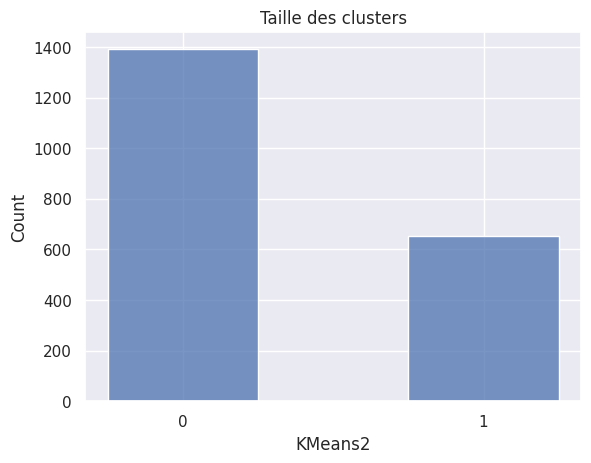

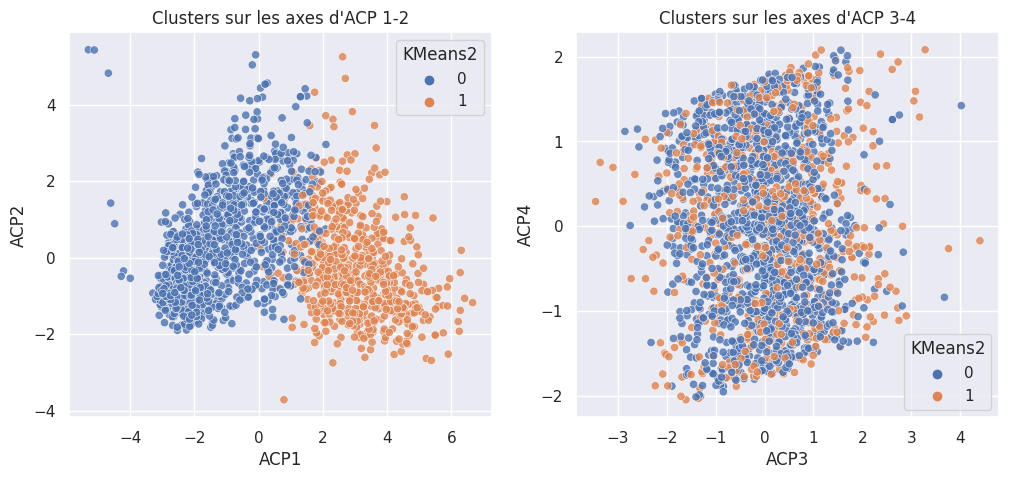

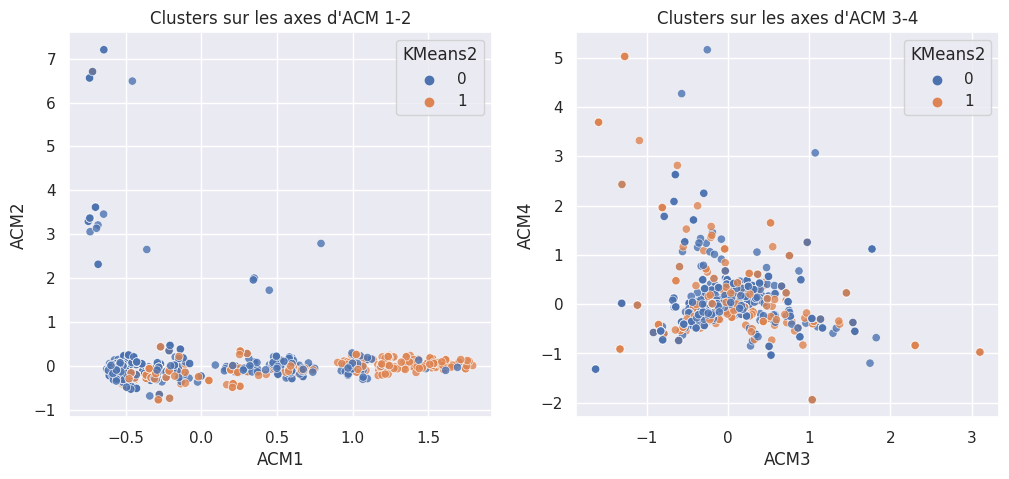

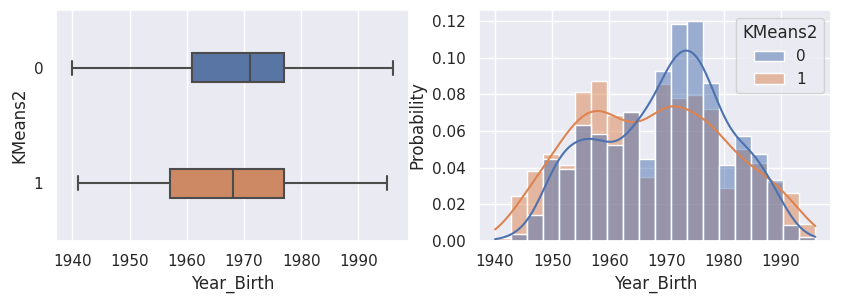

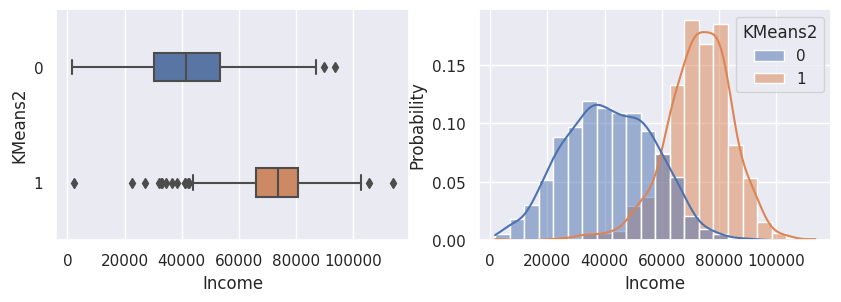

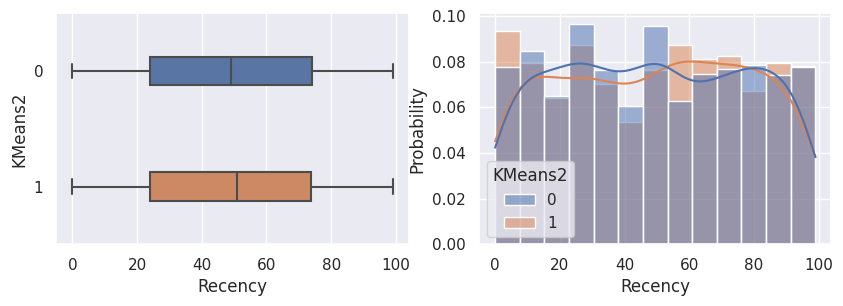

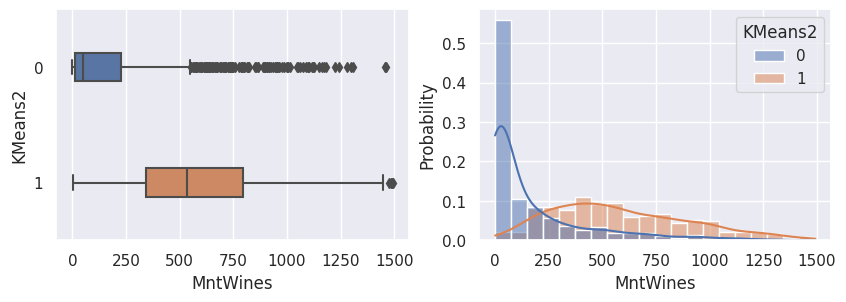

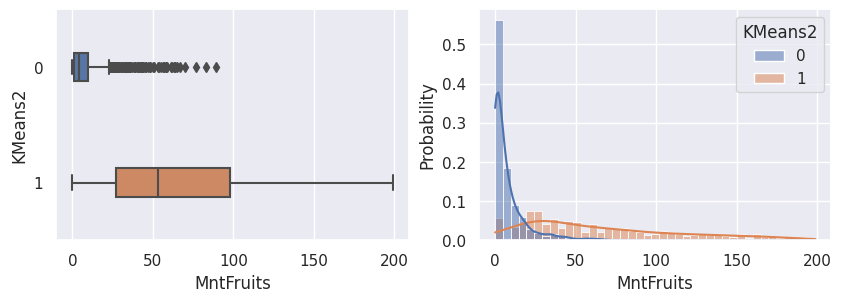

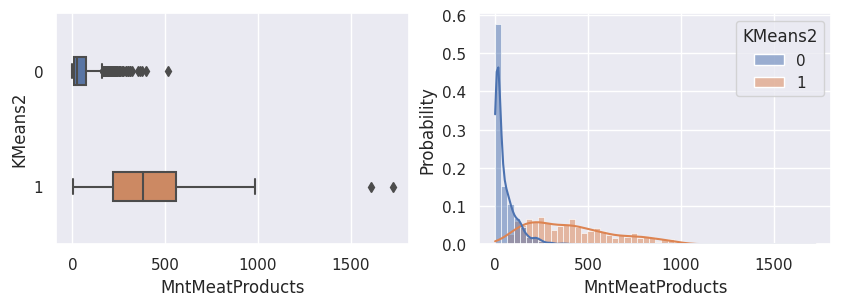

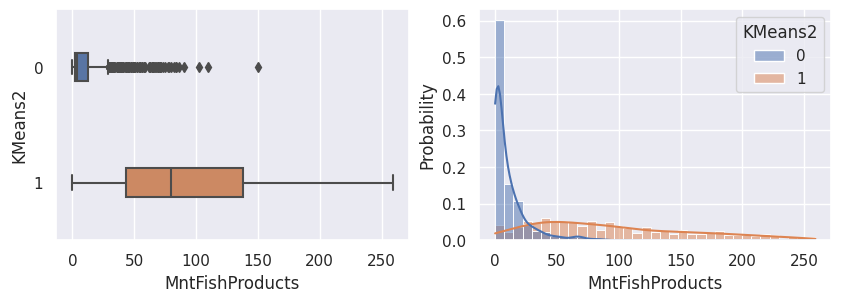

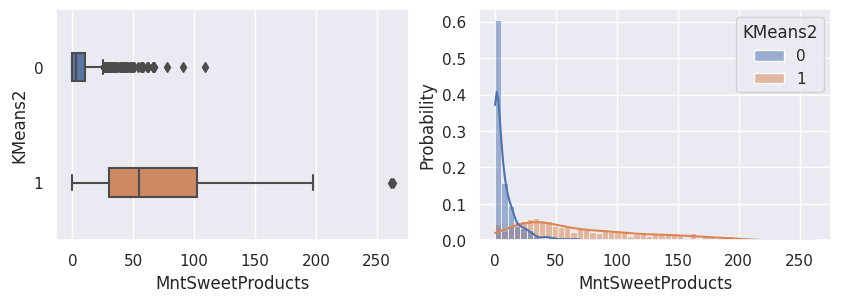

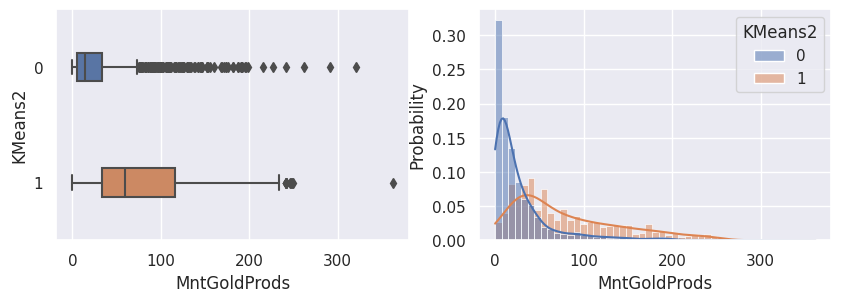

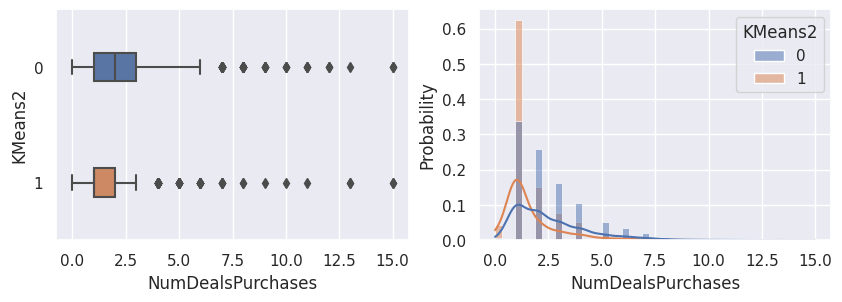

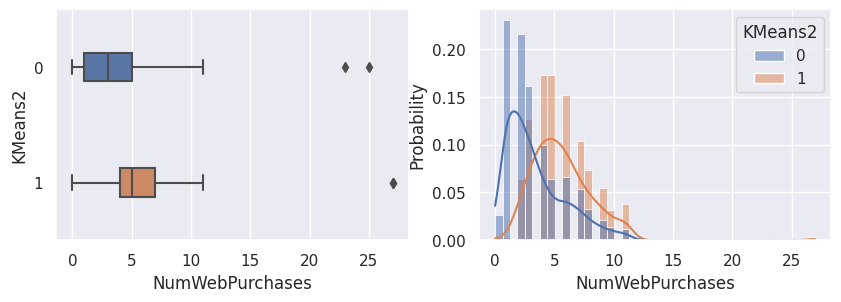

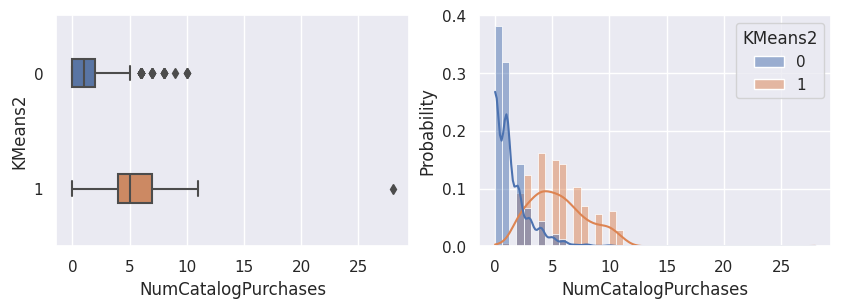

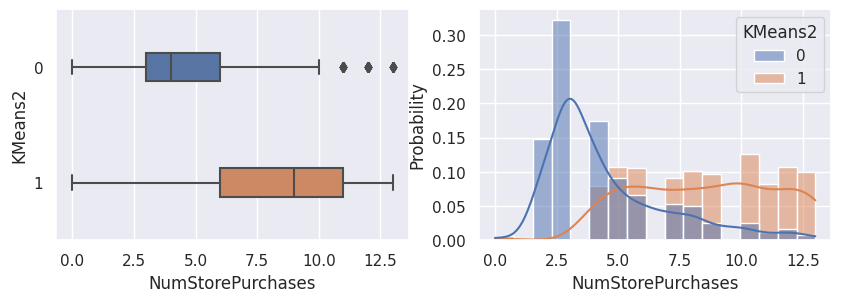

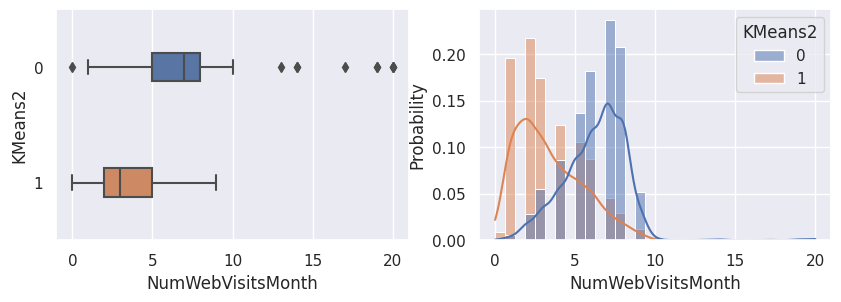

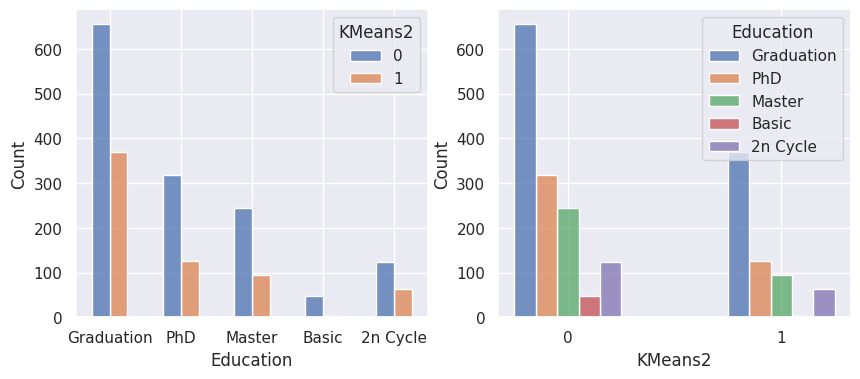

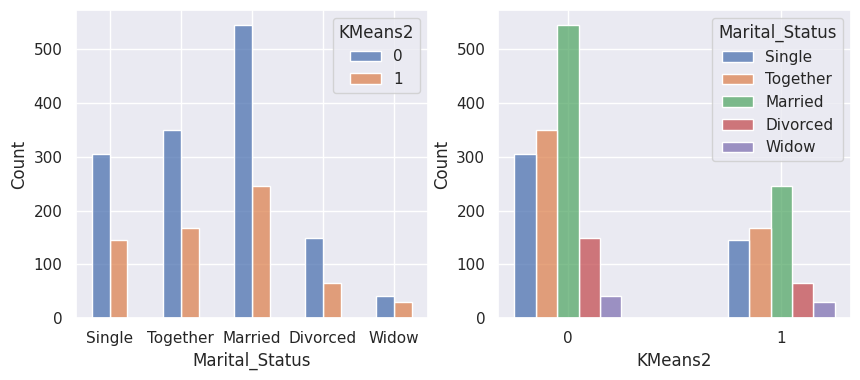

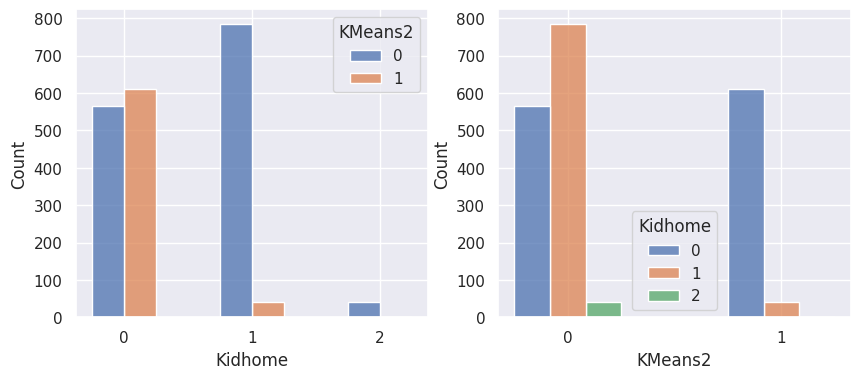

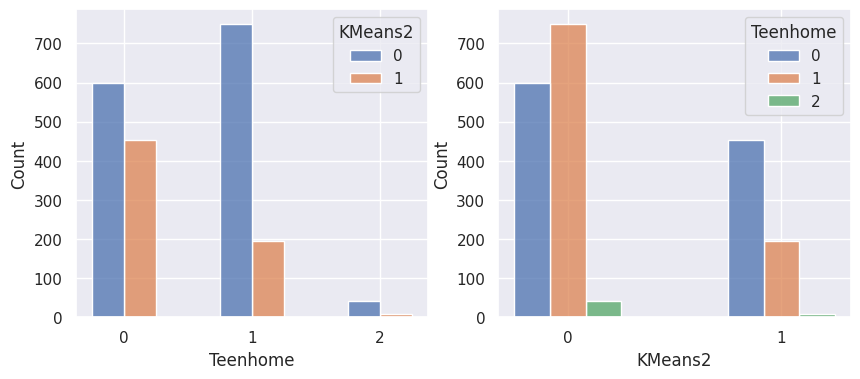

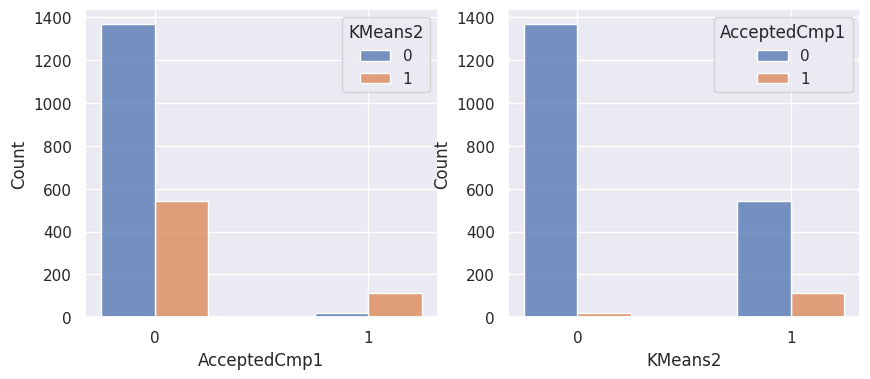

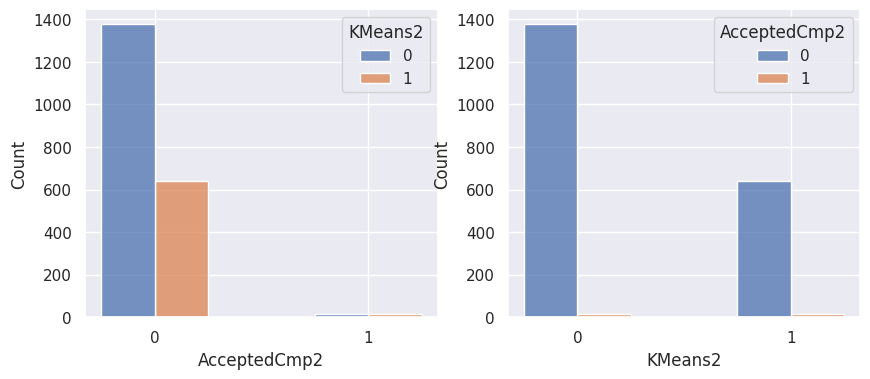

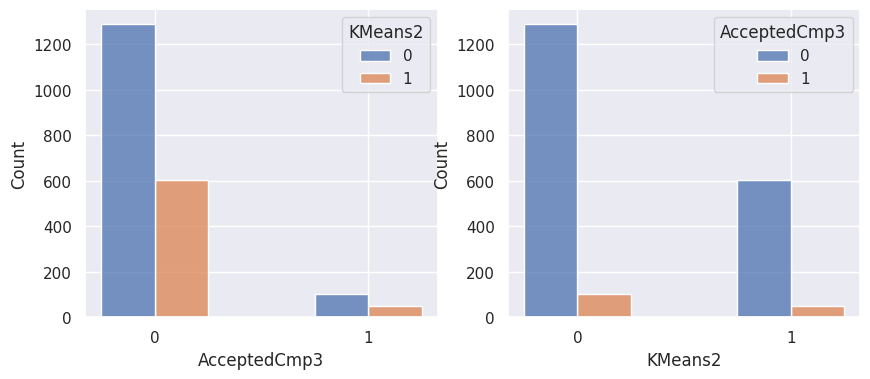

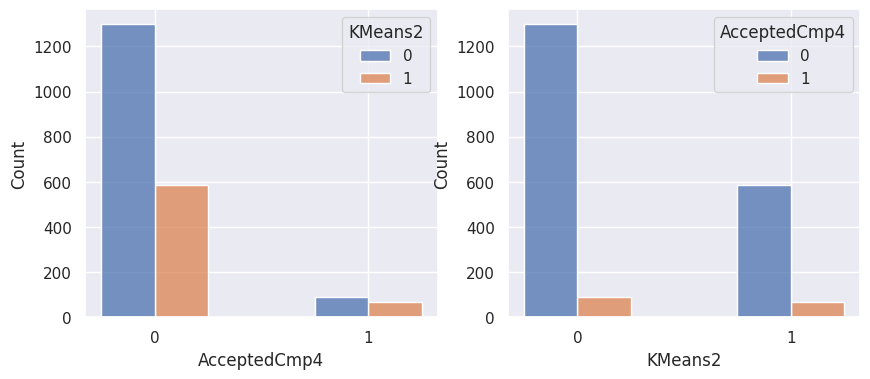

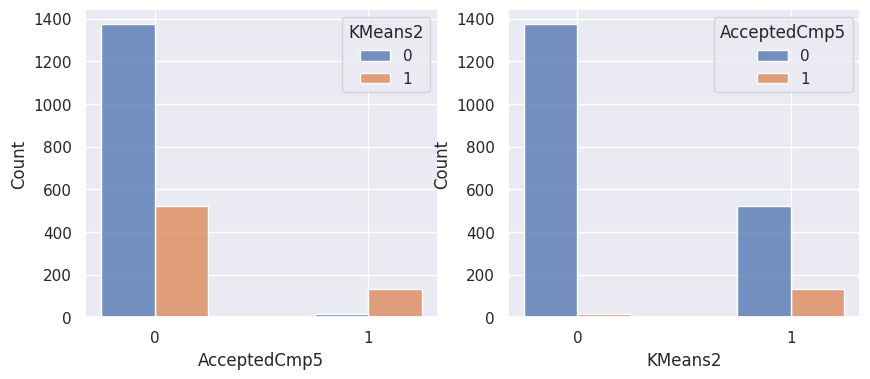

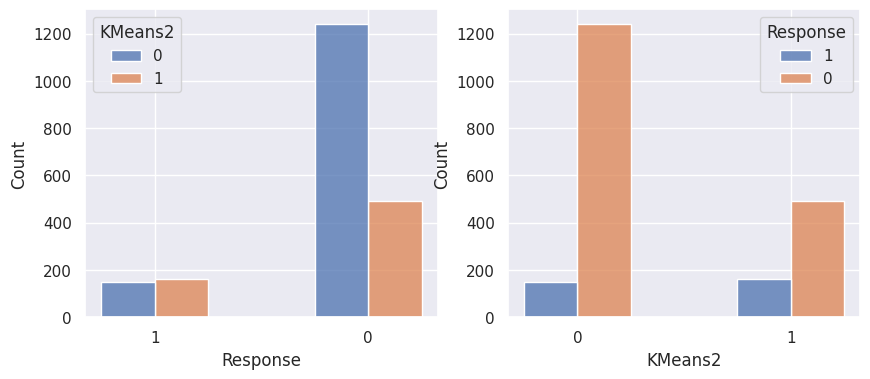

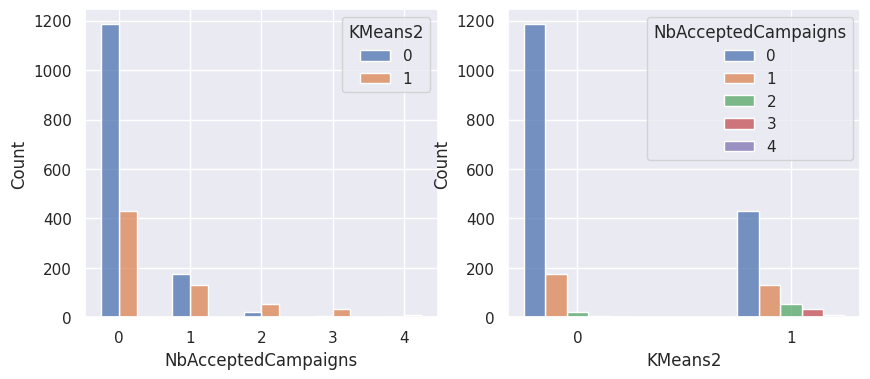

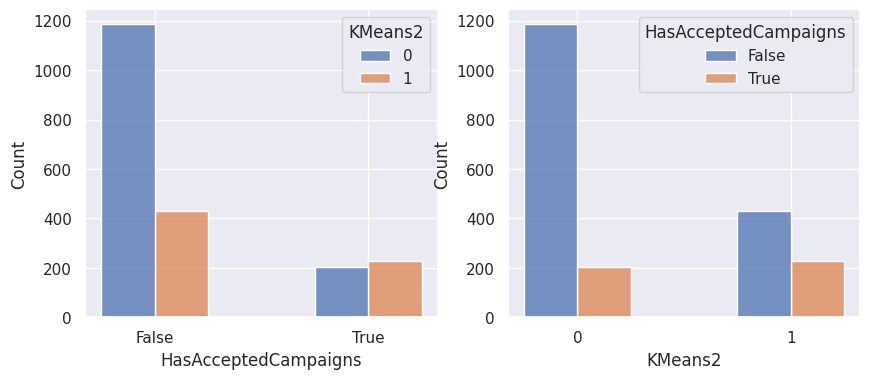

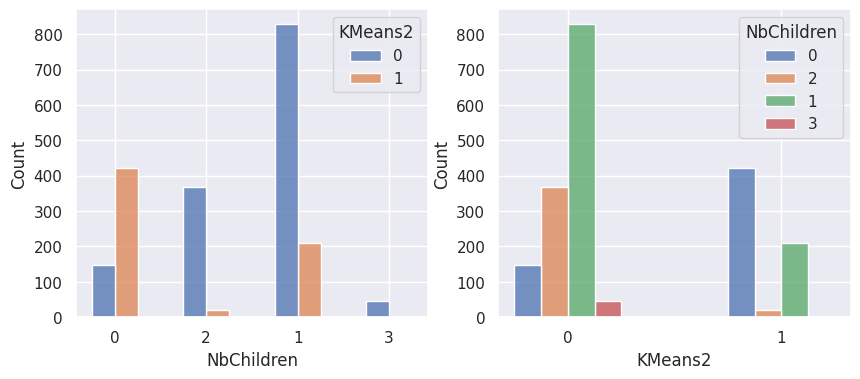

In [63]:
affiche_clusters("KMeans2")

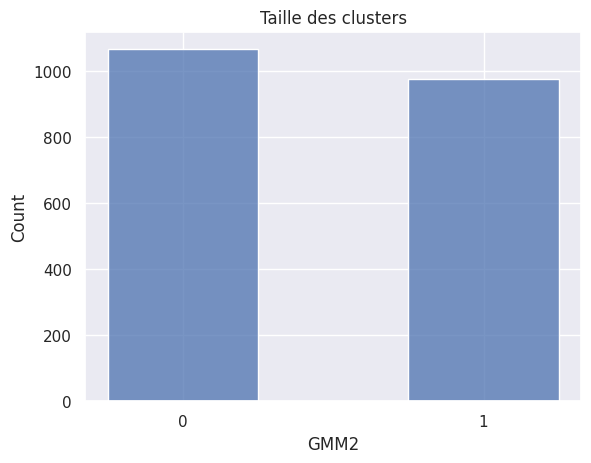

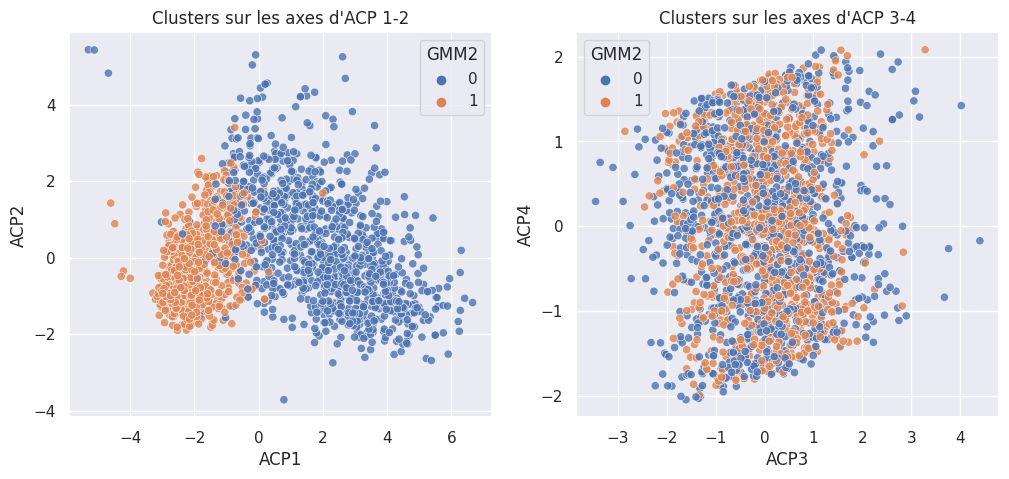

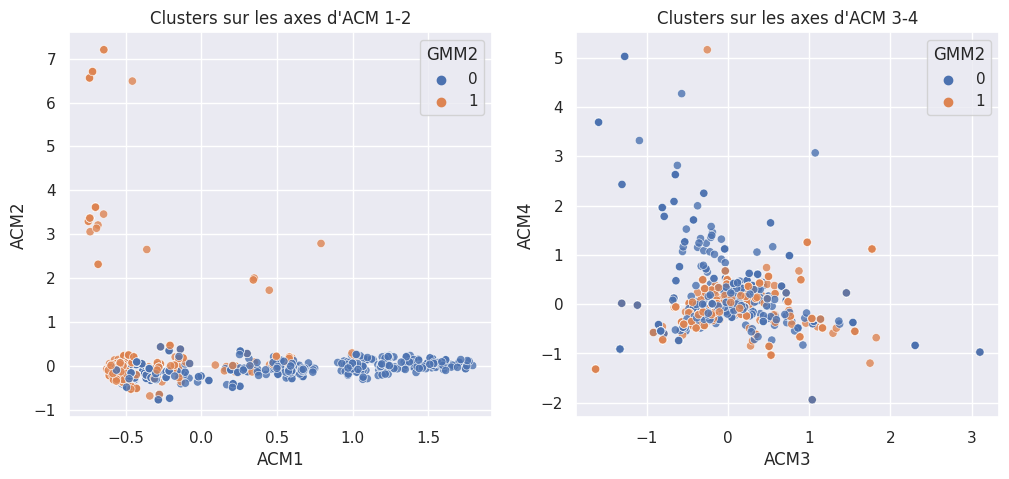

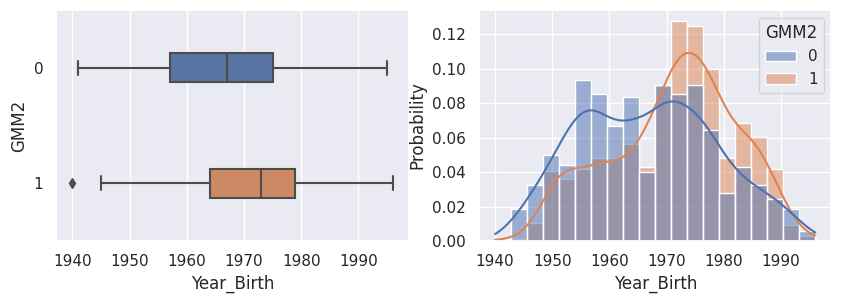

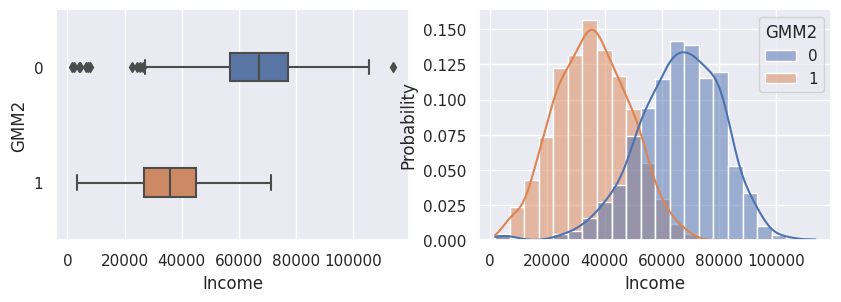

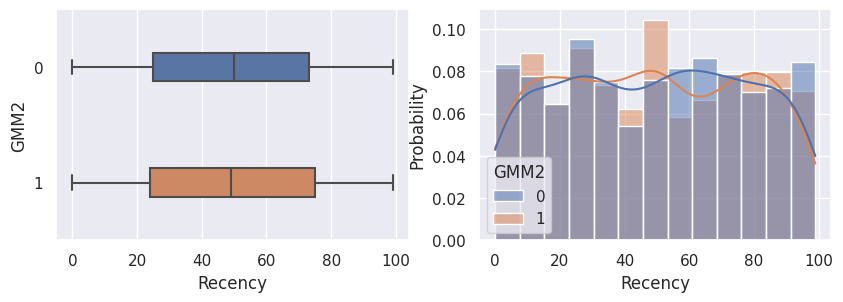

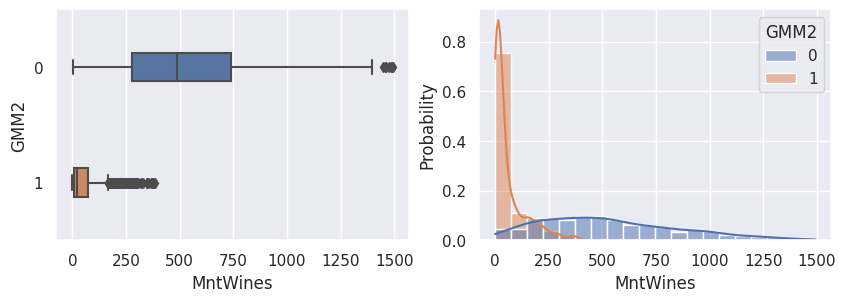

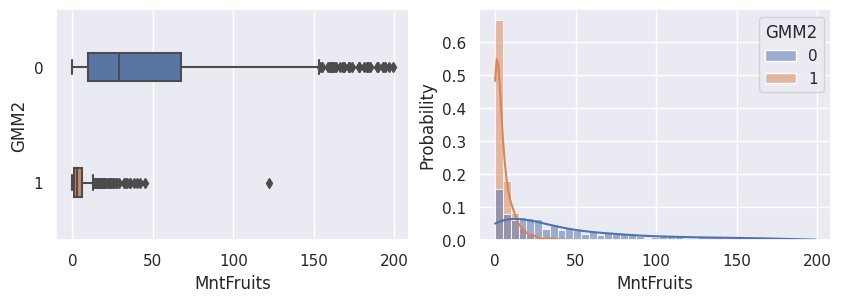

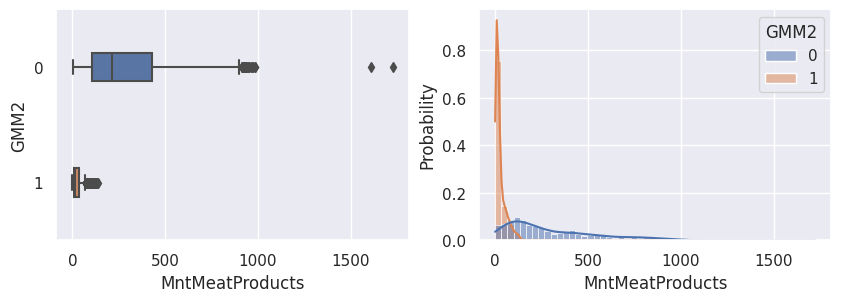

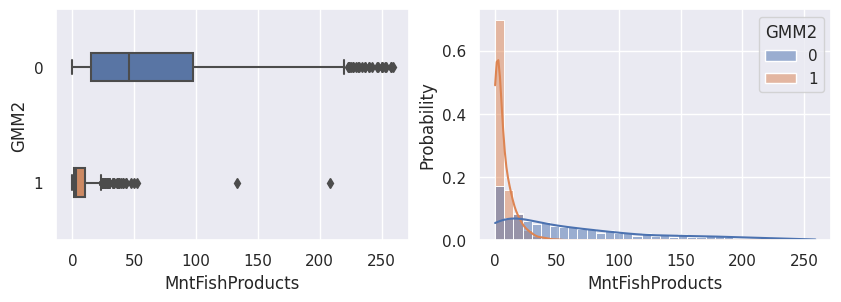

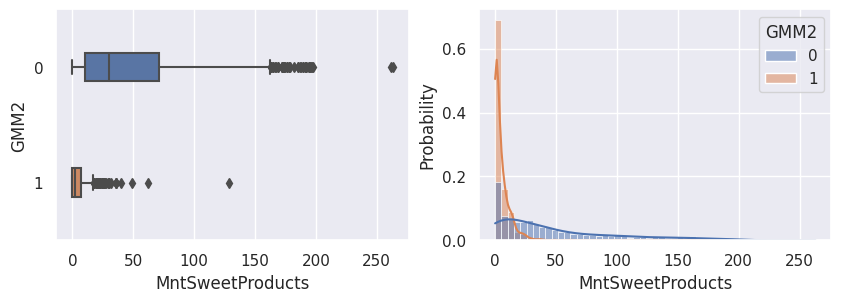

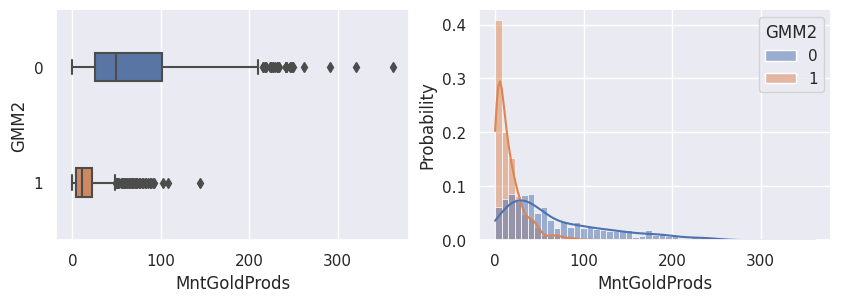

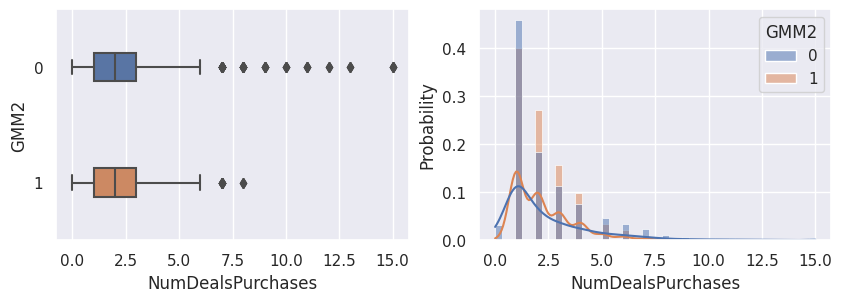

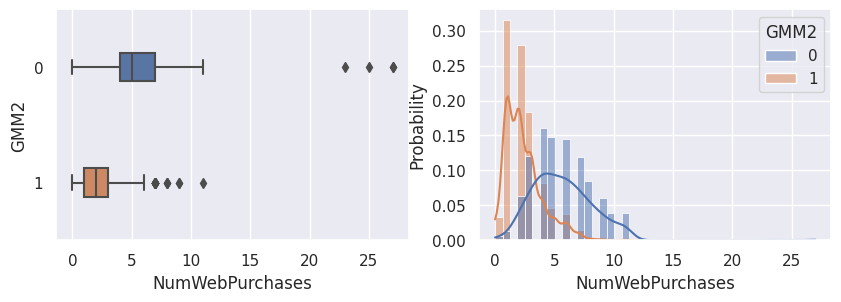

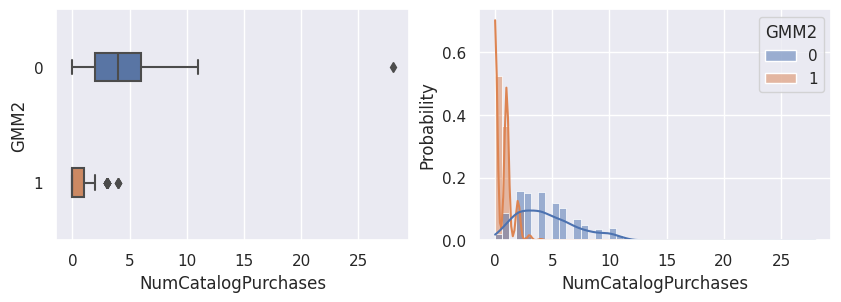

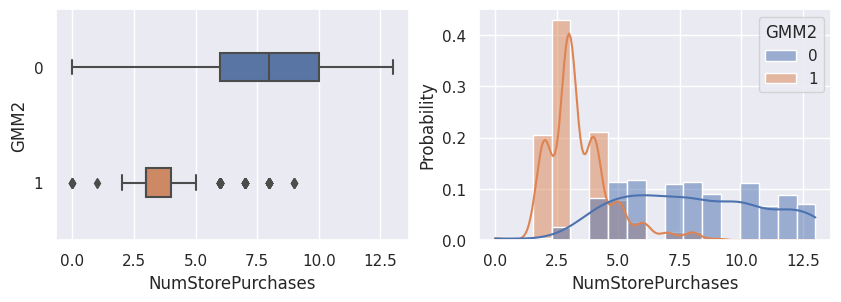

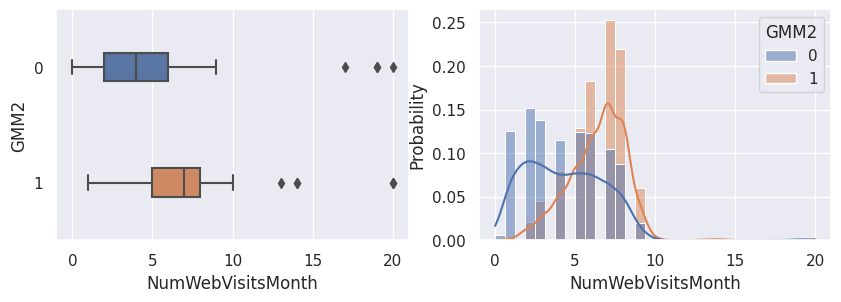

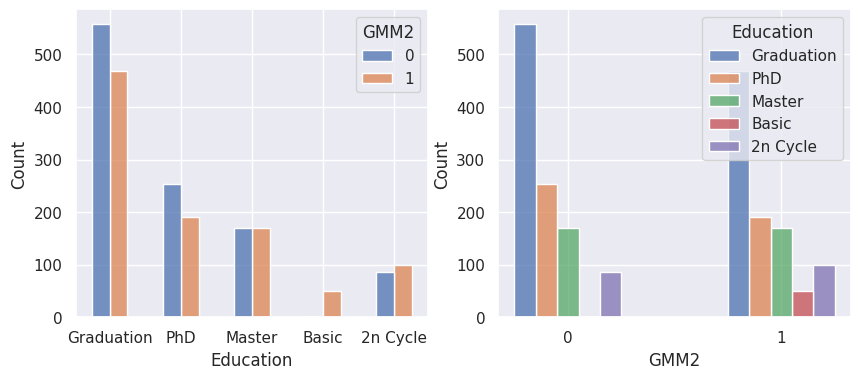

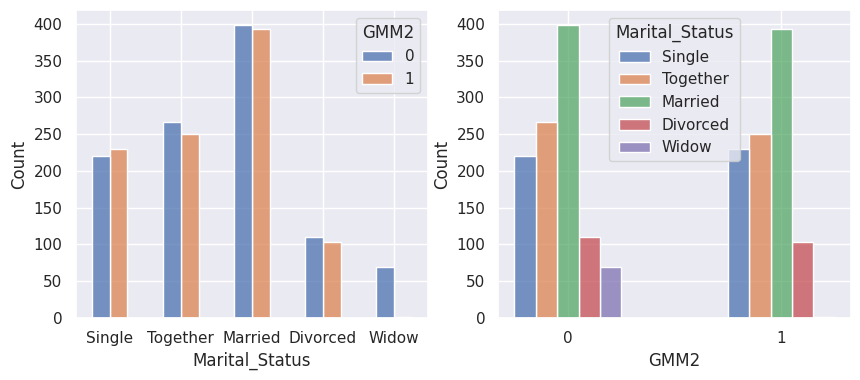

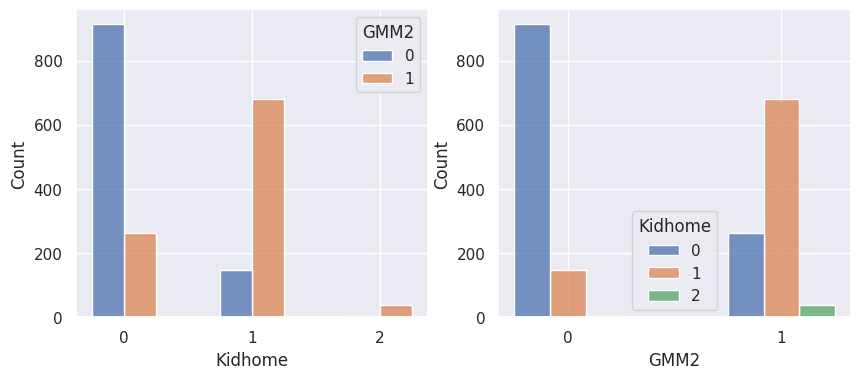

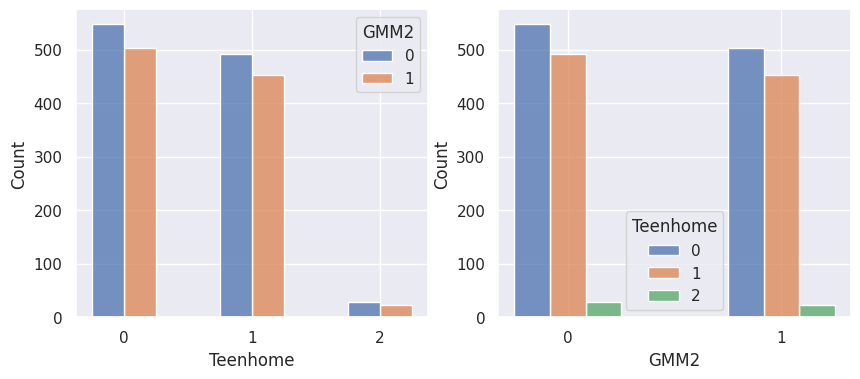

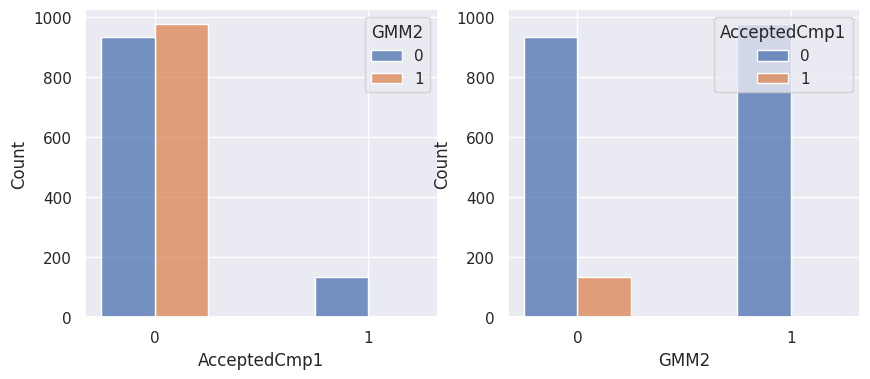

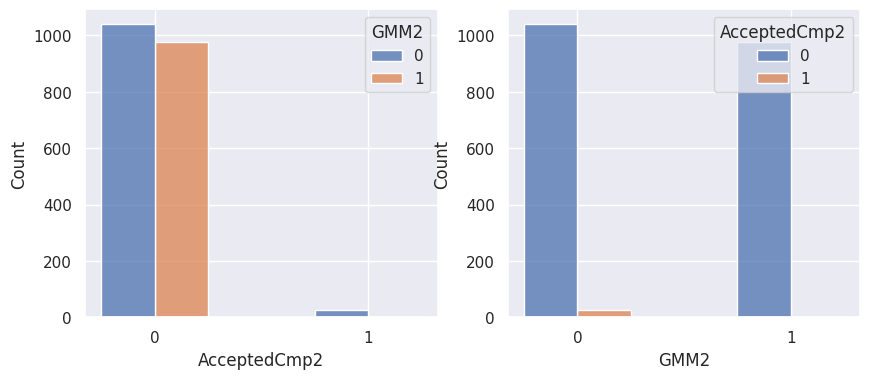

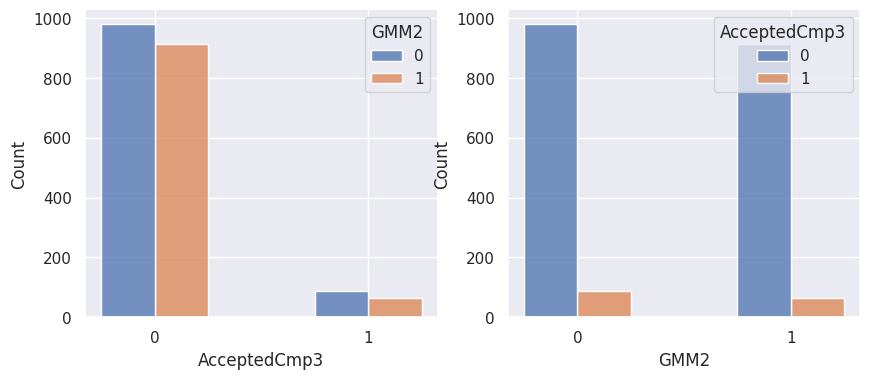

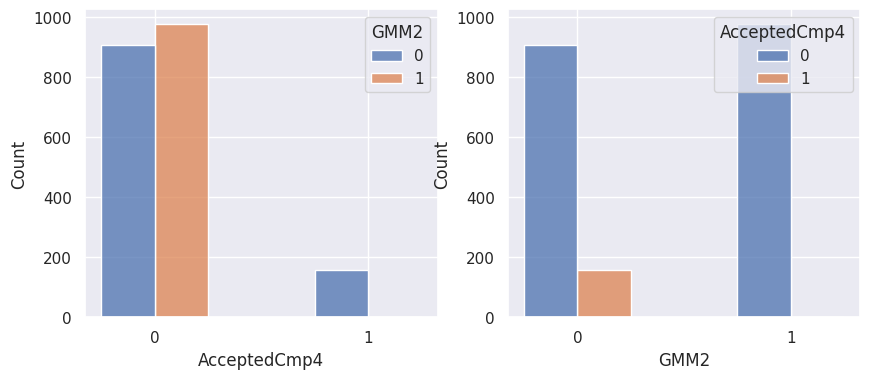

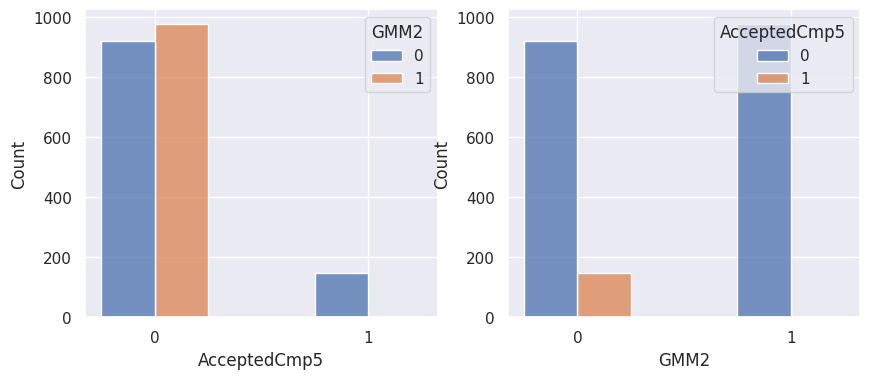

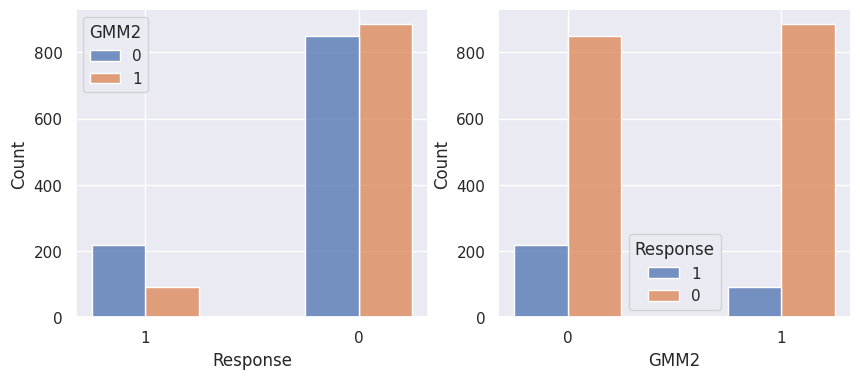

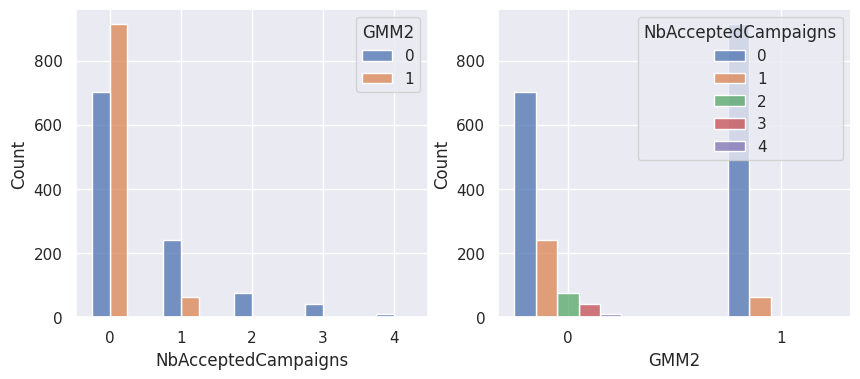

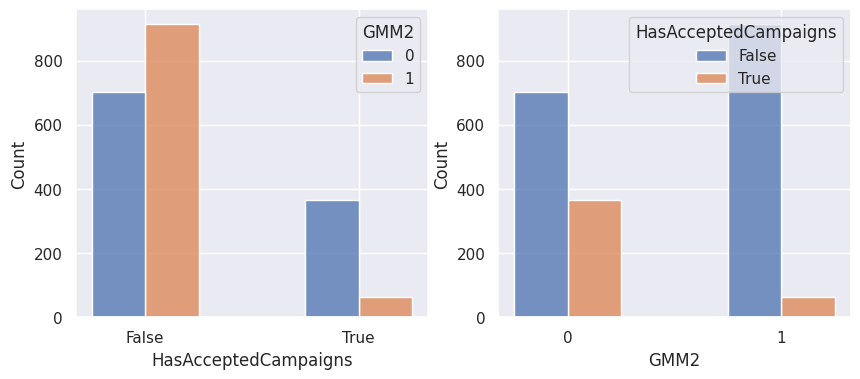

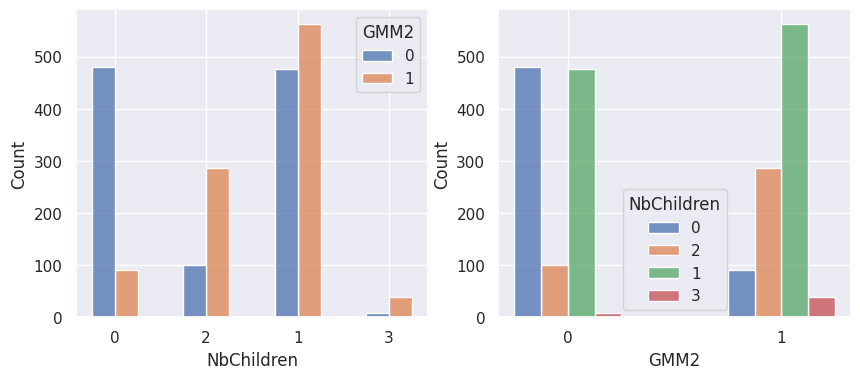

In [64]:
affiche_clusters("GMM2")

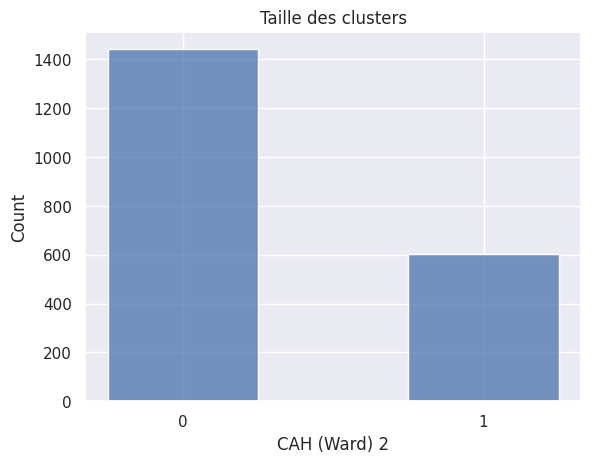

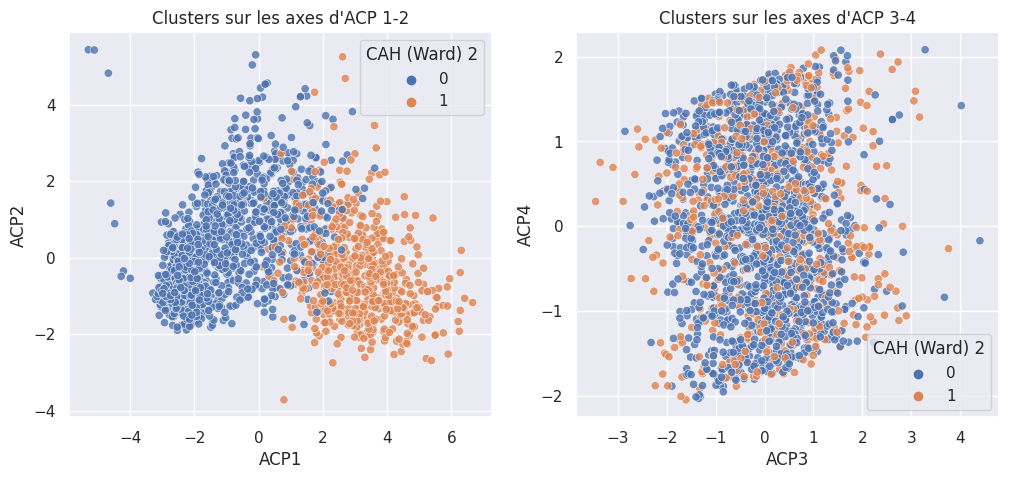

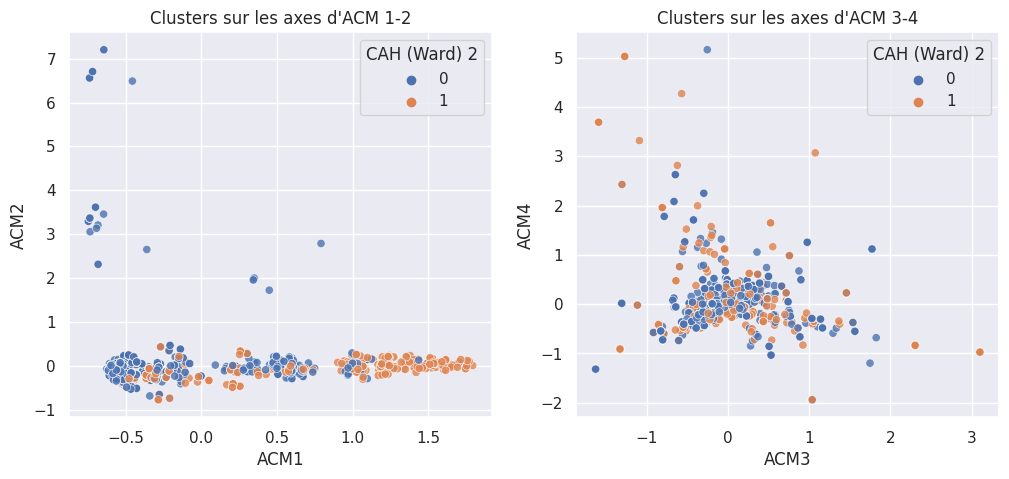

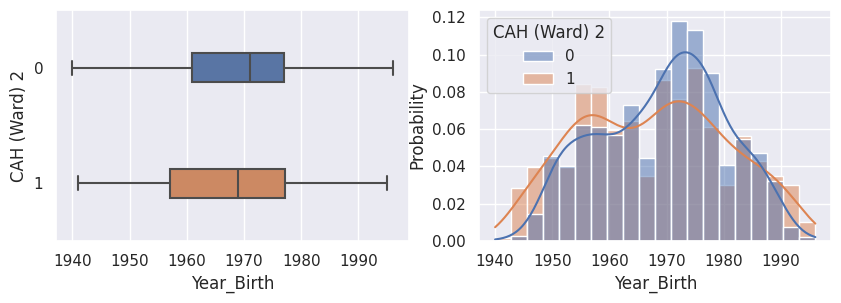

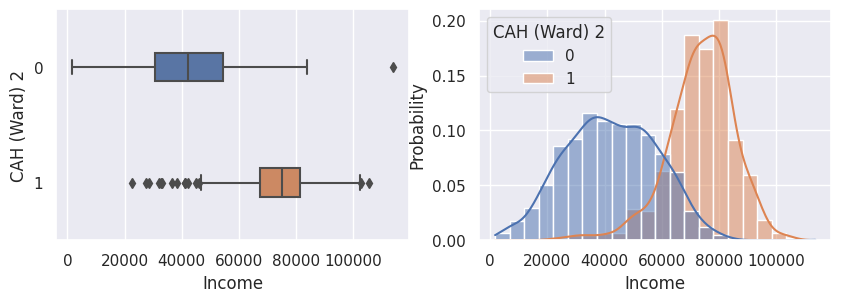

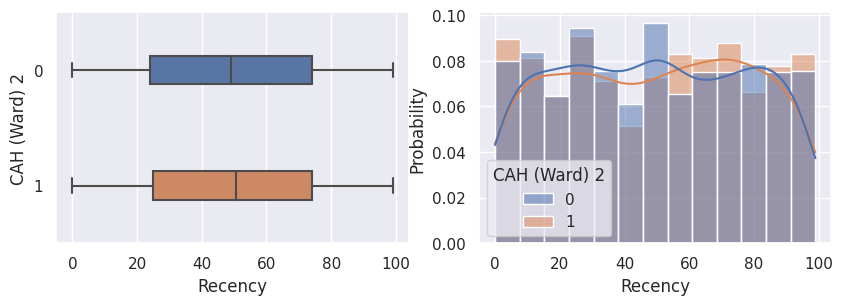

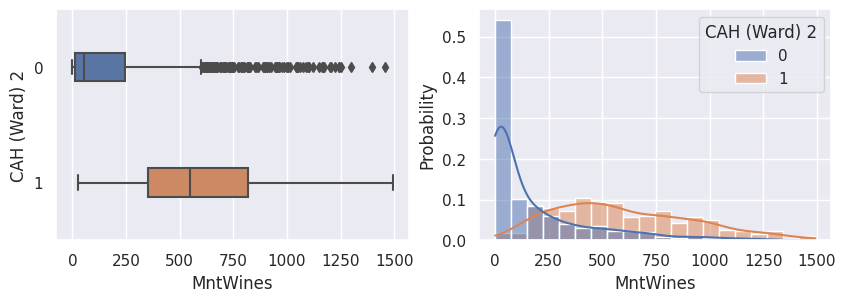

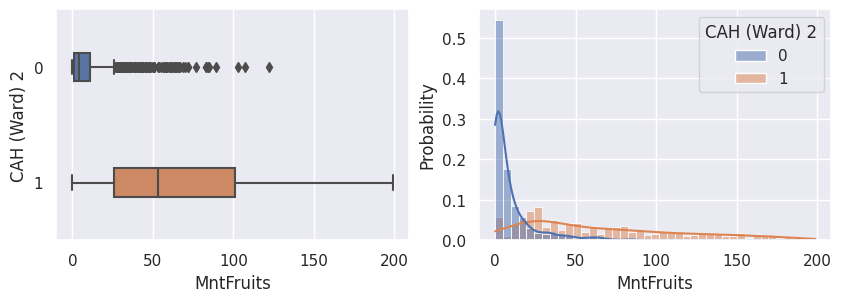

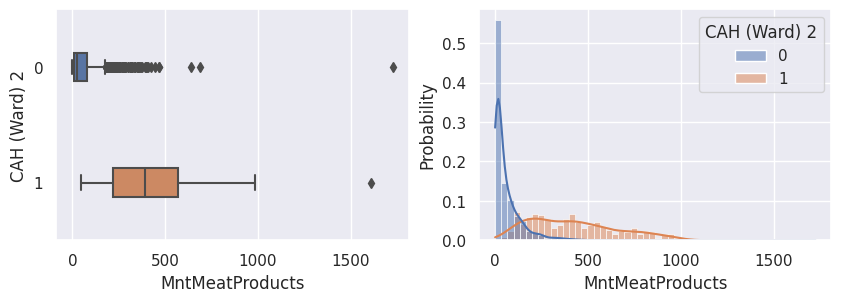

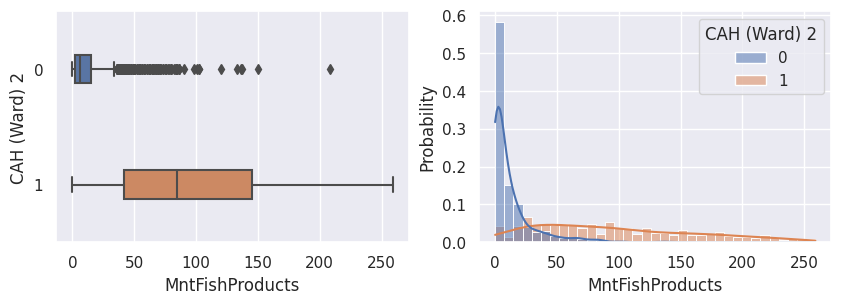

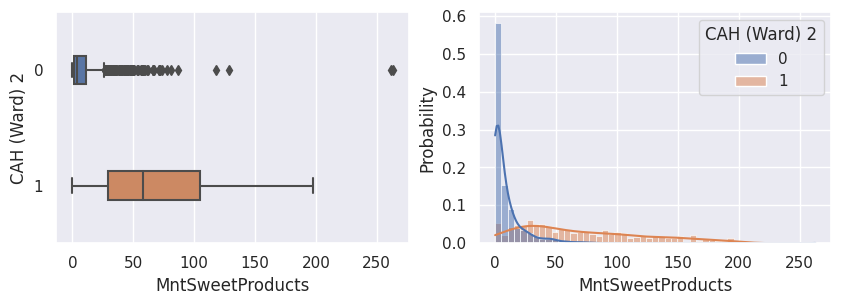

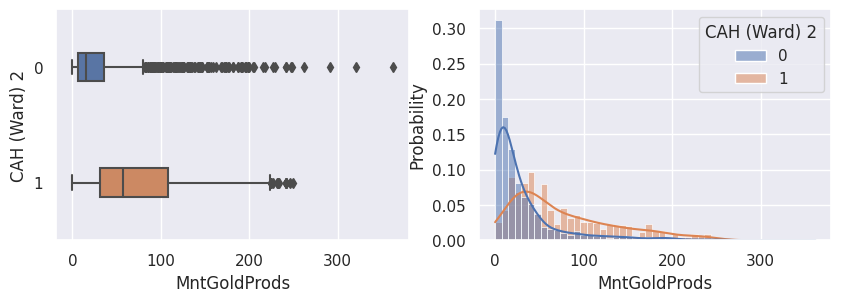

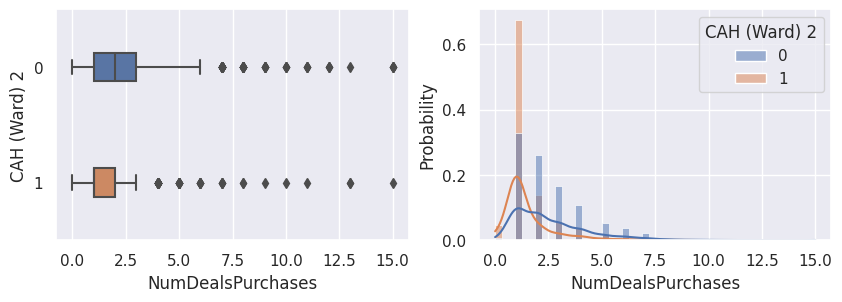

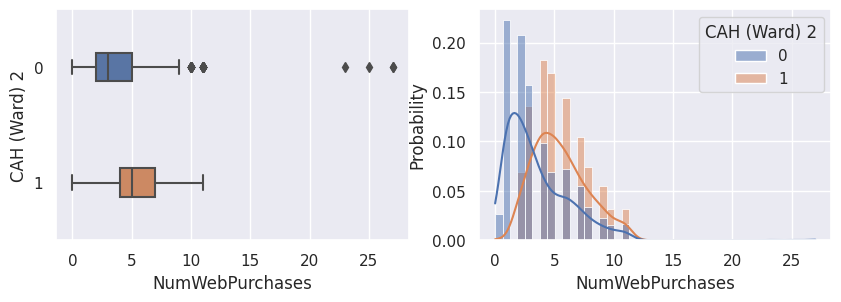

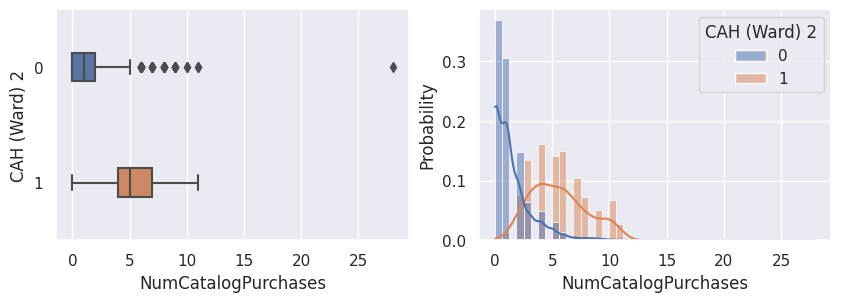

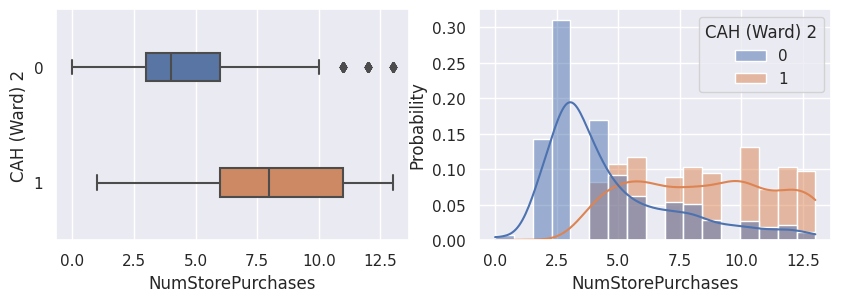

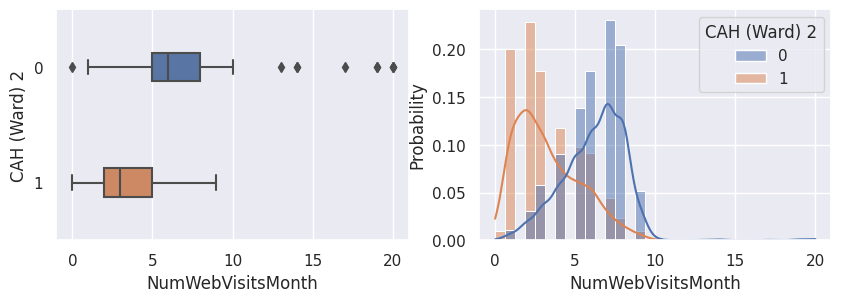

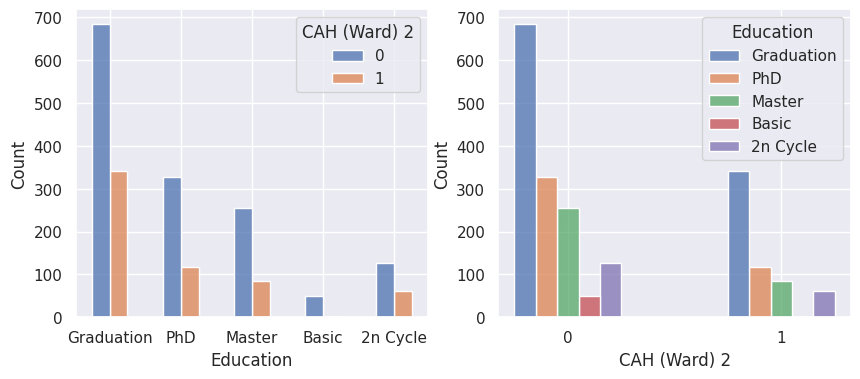

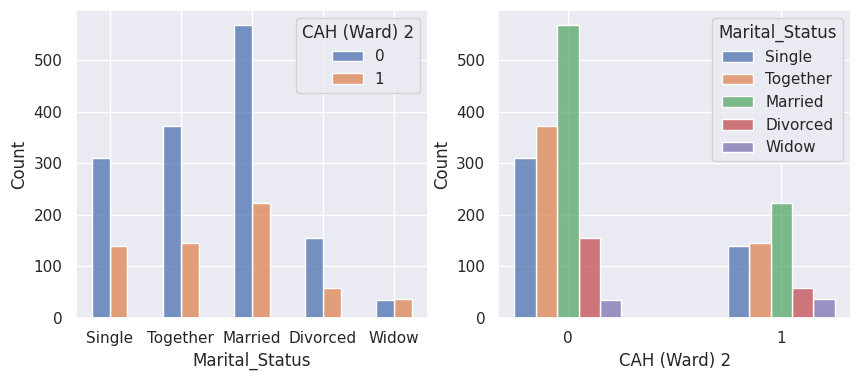

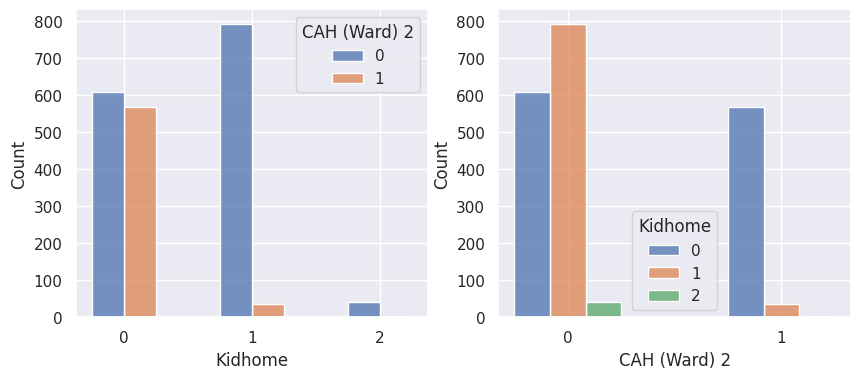

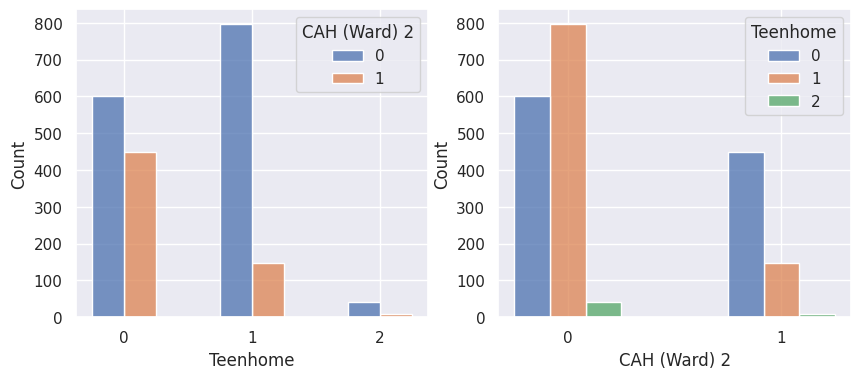

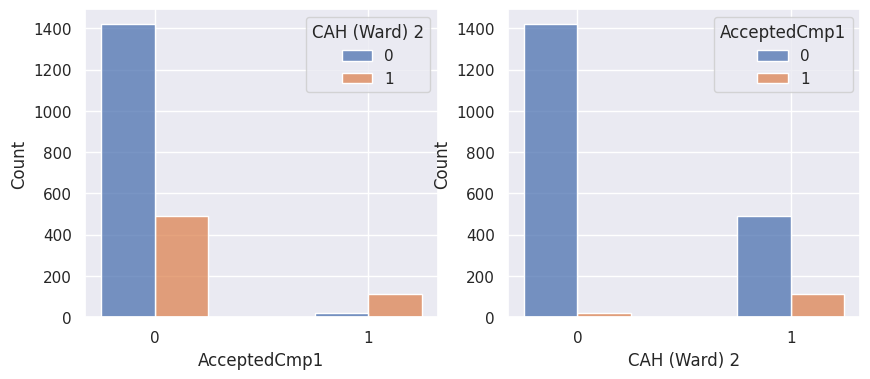

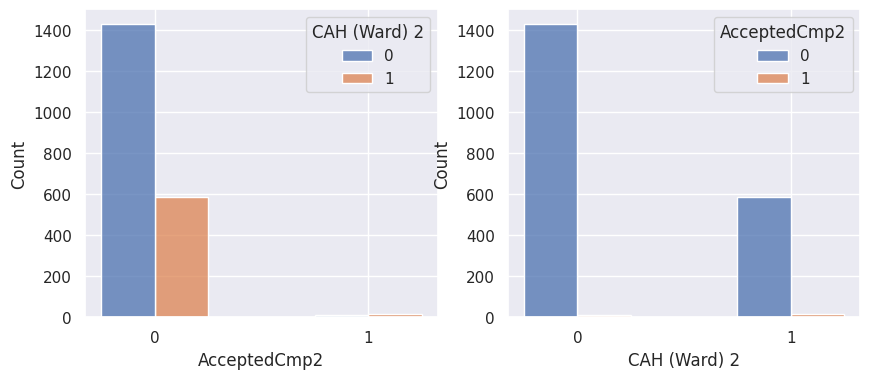

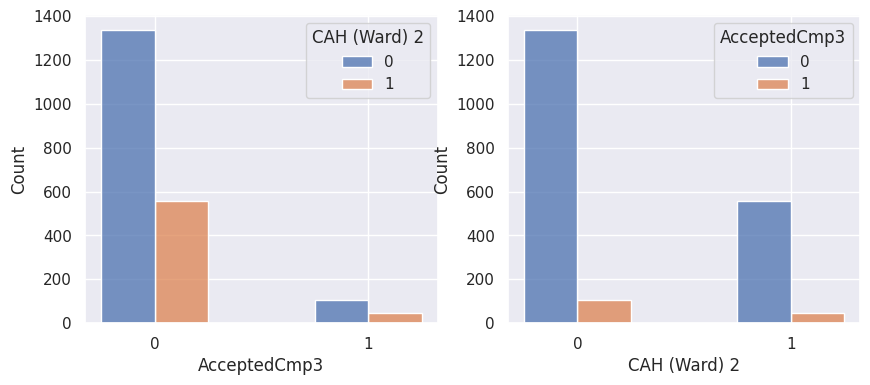

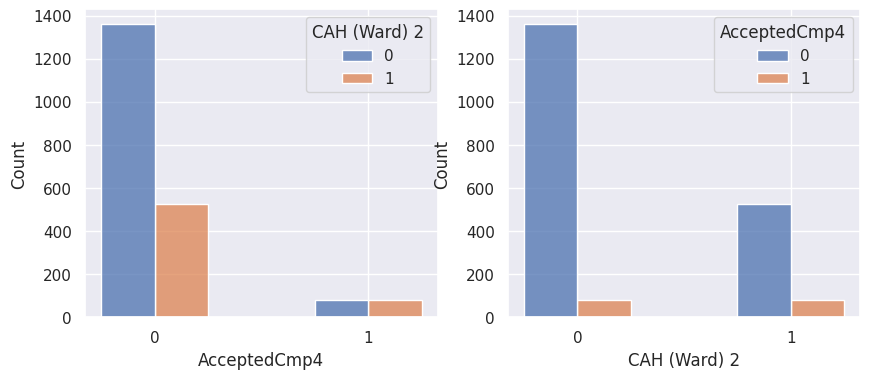

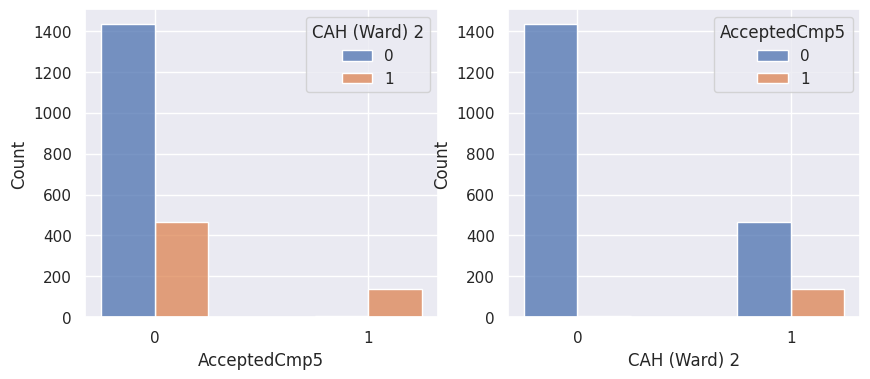

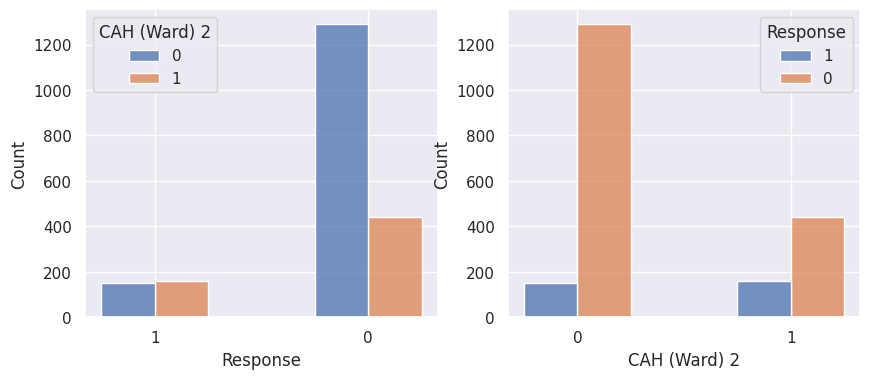

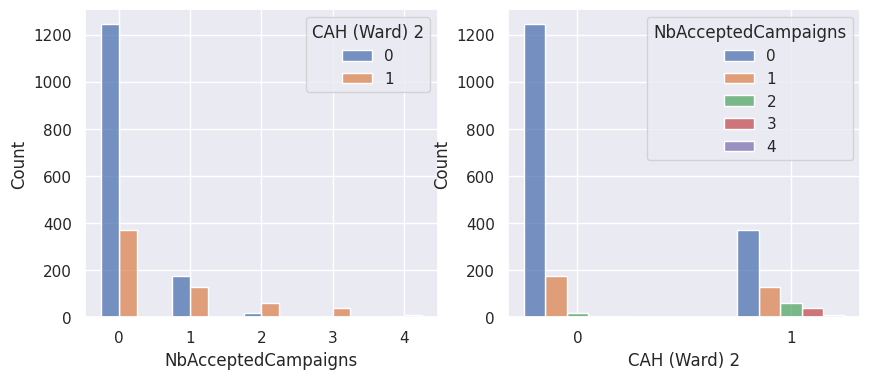

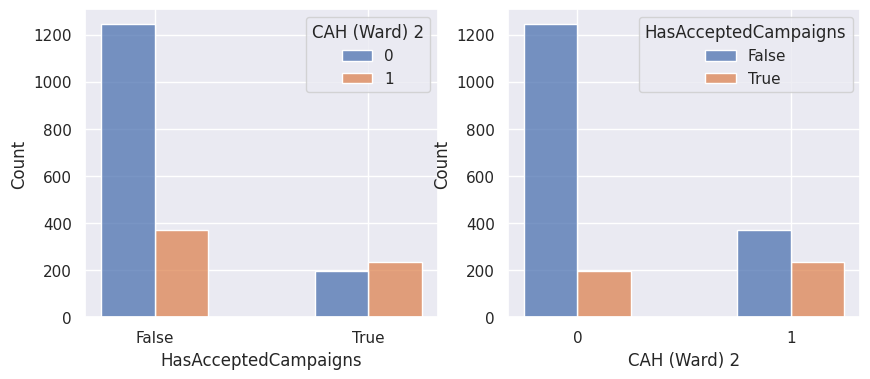

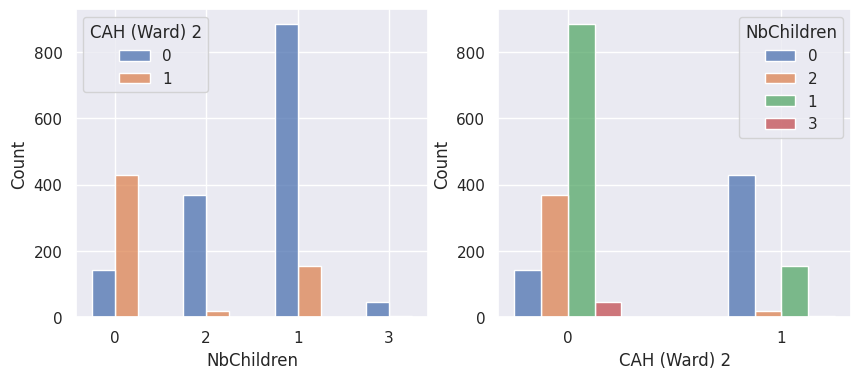

In [65]:
affiche_clusters("CAH (Ward) 2")

# Conclusion

**Tableau.** Description des clients types

| Profil                            | Proportion | Education         | Revenu          | Campagnes<br>acceptées | Enfants                          | Dépenses    |  Année de<br/>naissance | Site Internet |
|:----------------------------------|-----------:|:------------------|:----------------|-----------------------:|:---------------------------------|:------------|-------------------:|:--------------------|
| Clients qui achètent              |        30% | Bac - doctorat    | Élevé           |                    0-4 | 0 bas-âge <br/> 0-1 ado          | Élevées     |               1970 | Peu de visites      |
| Clients qui n'achètent pas ou peu |  68% - 70% | Brevet - doctorat | Moyen           |                    0-1 | 0-3 enfants<br/>(bas-âge et ado) | Peu élevées |               1970 | Beaucoup de visites |
| Clients qui n'achètent pas (n=3)  |         2% | Brevet            | Le plus faible  |                      0 | 0-1 bas-âge <br/> 0 ado          | Aucune      |               1980 | Beaucoup de visites |

Notons aussi que parmi les clients qui achètent, la proportion d'acceptation des campagnes est beaucoup plus élevée.

# Pour aller plus loin

- tester la stabilité des clusters (ici, l'initialisation des algorithmes a un impact significatif sur les clusters trouvés)
- tester les différents paramètres de chacun des algorithmes de clusters pour comparaison
- tester les algorithmes de clustering sur différents sous-ensembles de variables pour exhiber différents groupes

# Sauvegarde des données

In [66]:
# todo: sauvegarder les clusters